In [2]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.TTree
mcsangle:pl.DataFrame
dfana:pl.DataFrame

In [3]:
data_path = "/home/henrique/Documents/cernbox/Atmos_Pandora/data/ereco2/"
anatreeo = Anatree(f'', load_data=False)
anatreem = Anatree(f'', load_data=False)

In [4]:
nu: pl.DataFrame
reco_tracks:pl.DataFrame
nu_new:pl.DataFrame
reco_tracks_new:pl.DataFrame

anatreeo.read_parquet(f"../data/parquet_anatree_original_chi2_llhd_mcparticle/")
anatreem.read_parquet(f"../data/parquet_anatree_modified_chi2_llhd_mcparticle_chi2_with_constant_no_angle_correction/")
nuo = anatreeo.nu.collect()
num = anatreem.nu.collect()


Reading nu files... 33/33




Reading nu files... 33/33






In [5]:
def select_numu_cc(df:pl.DataFrame):
    df = df.filter(

        (pl.col('nuPDG_truth').abs() == 14) & (pl.col('ccnc_truth')==0)
    ).with_columns(
        E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
        Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>0).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>0).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
    )
    return df
dfnuo = select_numu_cc(nuo)
dfnum = select_numu_cc(num)
dfnuo

run,subrun,event,nuPDG_truth,ccnc_truth,nuvtxx_truth,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,lep_mom_truth,lep_dcosx_truth,lep_dcosy_truth,lep_dcosz_truth,mode_truth,nuWeight_truth,Q2_truth,W_truth,X_truth,Y_truth,pot,Ev_reco_nue,RecoLepEnNue,RecoHadEnNue,RecoMethodNue,Ev_reco_numu,RecoLepEnNumu,RecoHadEnNumu,RecoMethodNumu,LongestTrackContNumu,TrackMomMethodNumu,RecoLepEnNumu_range,RecoLepEnNumu_mcs_chi2,RecoLepEnNumu_mcs_llhd,Ev_reco_nc,nuvtxx,nuvtxy,nuvtxz,E,Echi2,Ellhd
i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f64,f32,f32,f32,i16,f32,f32,f32,i16,i16,i16,f32,f32,f32,f32,f64,f64,f64,f32,f32,f32
1497,1,25201,14,0,254.29213,-239.733795,850.396851,3.506681,0.474672,0.870252,-0.131727,2.105677,0.821558,0.558953,0.112317,1,3.9526248e7,2.051261,1.206727,0.78117,0.398769,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,2.586391,2.812985,-99999.0,254.069626,-239.660126,850.444031,2.108329,2.586391,2.812985
1497,1,25203,14,0,-97.171188,-419.298553,1227.462524,0.190718,0.846817,-0.04055,0.530347,0.08844,0.118292,0.165426,0.979102,0,6.8320936e7,0.020724,0.979918,0.208499,0.277534,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,0.0,-99999.0,-96.734985,-419.07431,1226.571167,0.137819,0.1,0.1
1497,1,25205,14,0,282.284546,68.525764,1332.67395,0.425602,0.698178,-0.507746,0.504728,0.220373,0.190629,0.952567,0.237227,0,4.589922e7,0.240167,0.990799,0.705791,0.425771,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.273967,0.263144,-99999.0,282.33728,68.317558,1332.552856,0.244411,0.273967,0.263144
1497,1,25207,14,0,-283.344482,-603.713989,72.588226,0.944176,-0.916382,0.345722,0.201821,0.691383,-0.472335,0.154903,0.867701,0,4.9776868e7,0.445923,0.94619,0.970178,0.259238,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,1.538454,0.590529,-99999.0,-294.94519,-600.667542,90.954056,0.699416,1.538454,0.590529
1497,1,25210,14,0,-24.515333,-417.449921,1244.540894,0.475076,-0.134197,-0.761705,-0.633878,0.345829,0.59541,-0.725239,-0.345709,0,4.5548472e7,0.105151,0.994731,0.493499,0.238839,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.388426,0.385752,-99999.0,-24.335058,-416.961304,1244.40625,0.361622,0.388426,0.385752
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6422672,1,74380,14,0,-312.18338,-507.415344,687.152588,1.434003,-0.700736,0.65345,0.28632,1.093332,-0.759753,0.608159,0.230039,10,4.50365e7,0.017091,1.222554,0.027122,0.234015,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,1.897596,1.524665,-99999.0,-312.254364,-507.710876,687.050293,1.098429,1.897596,1.524665
6422672,1,74383,14,0,20.392897,-294.022614,882.10498,7.449443,0.510239,0.663371,0.547359,6.666778,0.591083,0.57555,0.565122,1,3.304482e7,0.724648,1.274781,0.49358,0.104951,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,5.337454,100.001053,-99999.0,20.298048,-293.670746,881.878235,6.667615,5.337454,100.001053
6422672,1,74388,14,0,-195.466644,-153.641449,1164.100342,15.473072,0.195525,0.206517,-0.958714,13.617494,0.133877,0.181897,-0.974161,2,3.2085246e7,0.980646,1.839736,0.281495,0.119897,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,100.001053,-99999.0,-195.318405,-153.313034,1163.052856,13.617904,0.1,100.001053


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


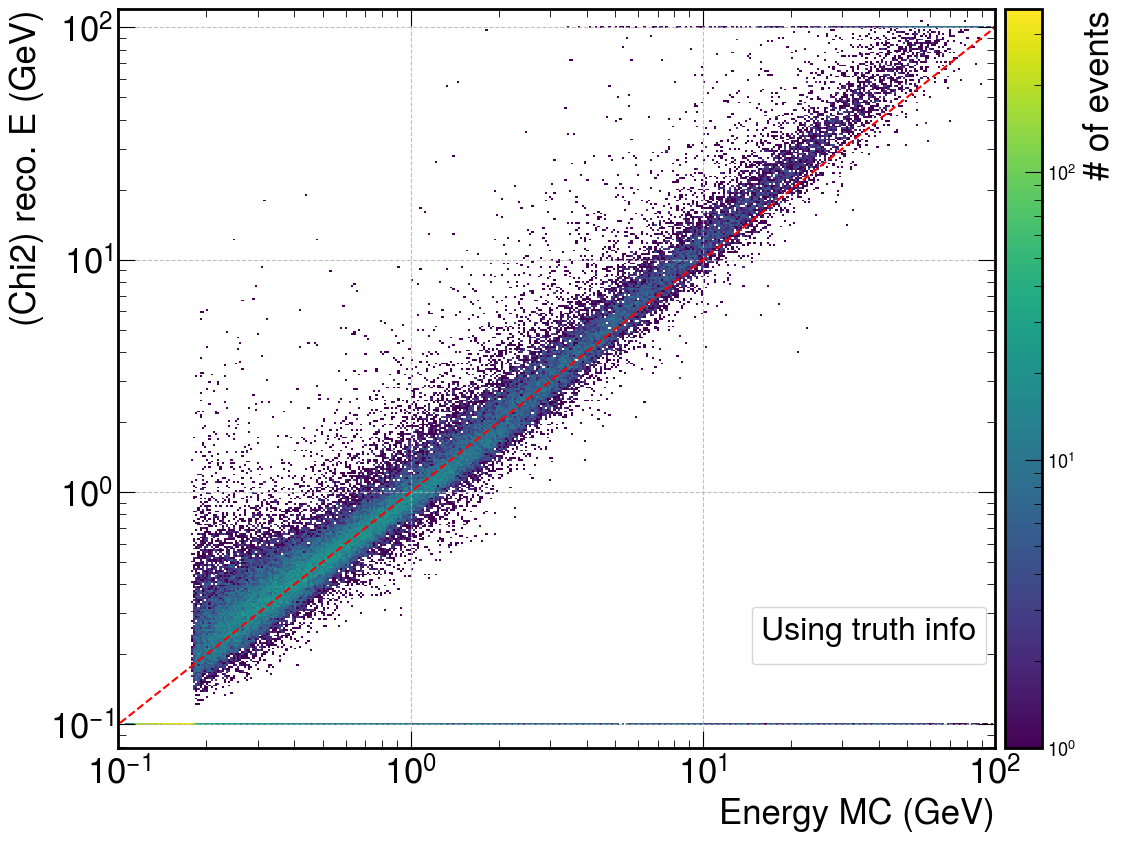

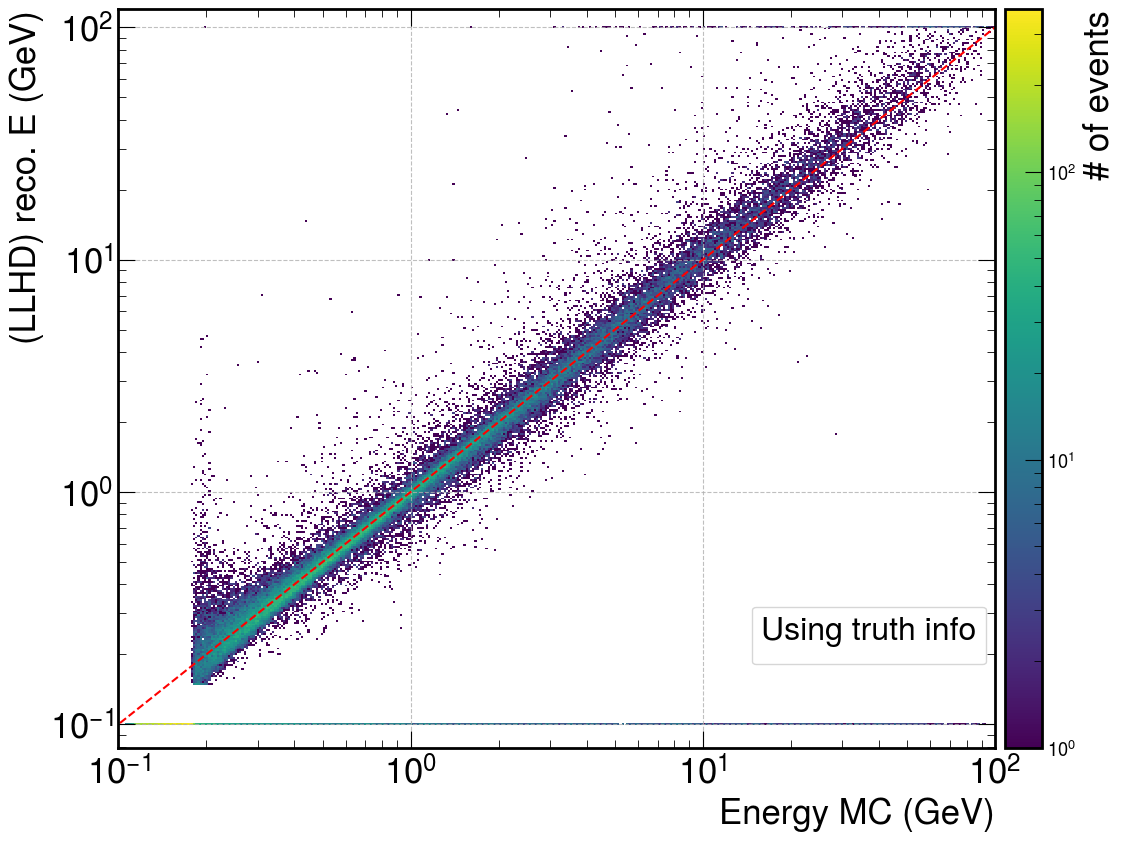

In [6]:
def plot_mu_vs_mu(Emu:pl.DataFrame, label, lmethod, x='E', y='RecoLepEnNumu'):

    fig = plt.figure(figsize=(12,8.7))
    binsx = np.logspace(-1,2,400)
    binsy = np.logspace(-1.1,np.log10(120),400)
    fontsize=25
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm='log');
    plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('Energy MC (GeV)', fontsize=fontsize)
    plt.ylabel(f'{label} reco. E (GeV)', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    legend = plt.legend(frameon=True, title=lmethod, loc='lower right', bbox_to_anchor=(0,0.1,1,1))
    plt.setp(legend.get_title(),fontsize='x-large')

# plot_mu_vs_mu(Emu.filter(pl.col('rec.LongestTrackContNumu')==1), label='(old)')
plot_mu_vs_mu(dfnum,  y='Echi2', label='(Chi2)', lmethod='Using truth info')
plot_mu_vs_mu(dfnum,  y='Ellhd', label='(LLHD)', lmethod='Using truth info')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


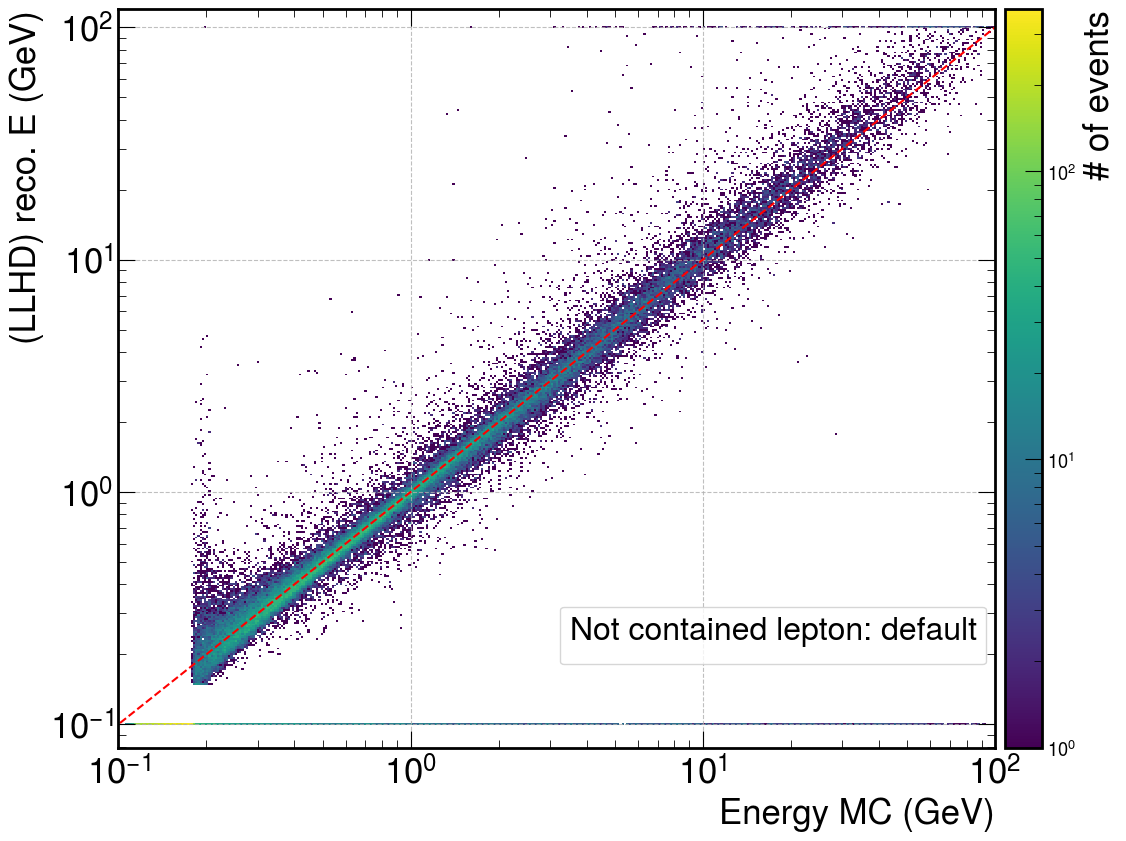

In [7]:

plot_mu_vs_mu(dfnum,  y='Ellhd', label='(LLHD)', lmethod='Not contained lepton: default')
# plot_mu_vs_mu(dfnu.filter(pl.col('LongestTrackContNumu')==0),  y='Ellhd_new', label='(LLHD)', lmethod='Not contained lepton: new')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


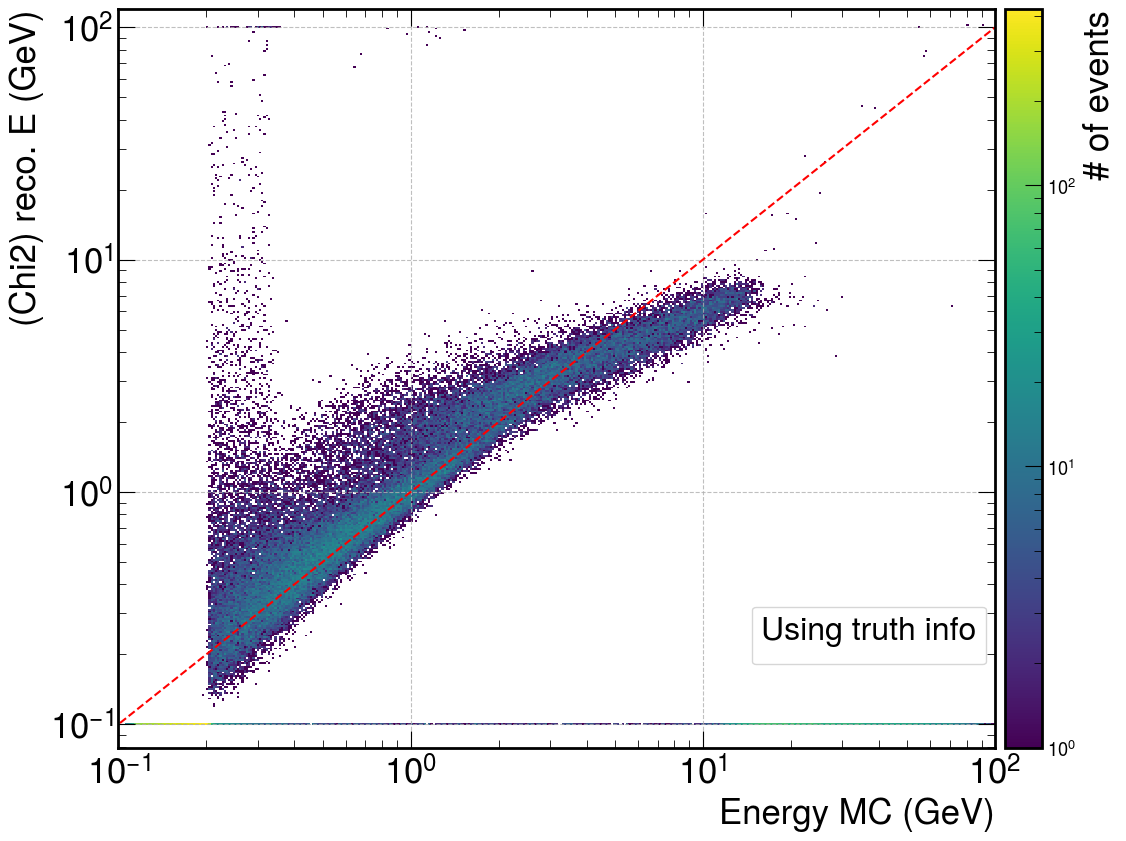

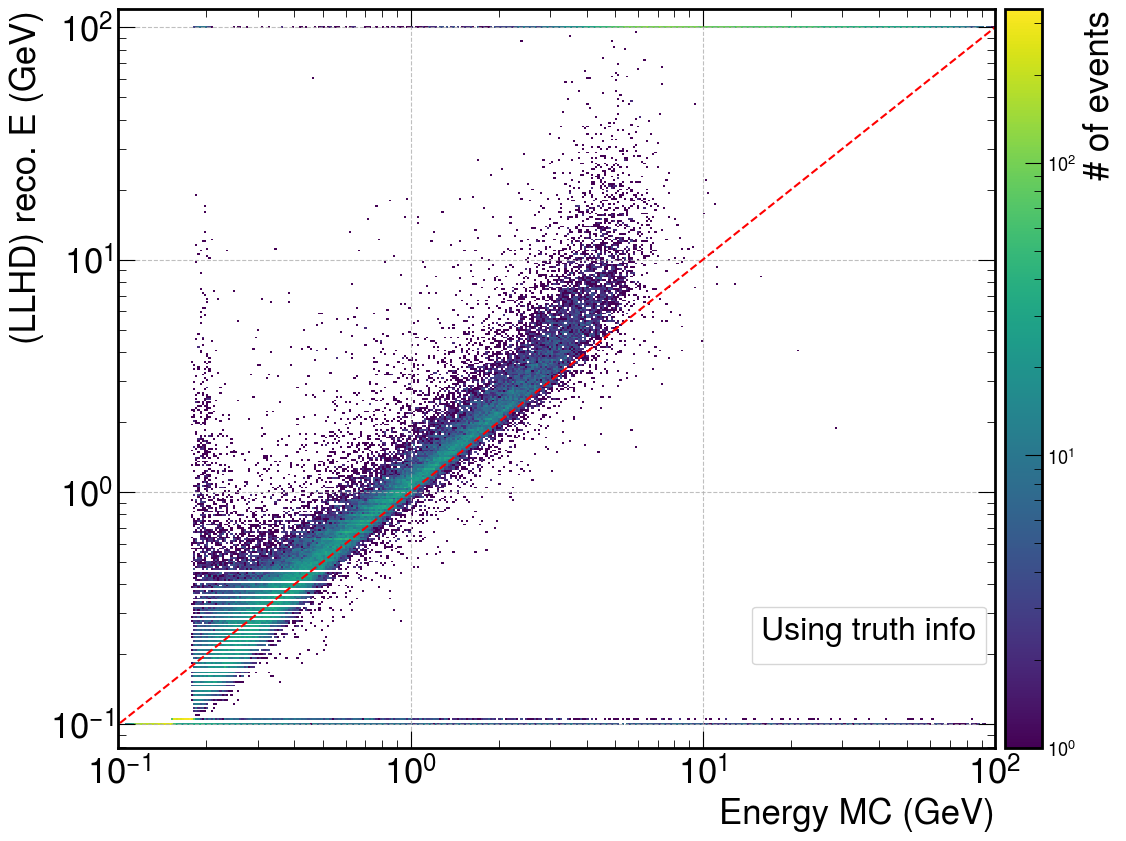

In [21]:
plot_mu_vs_mu(dfnuo,  y='Echi2', label='(Chi2)', lmethod='Using truth info')
plot_mu_vs_mu(dfnuo,  y='Ellhd', label='(LLHD)', lmethod='Using truth info')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


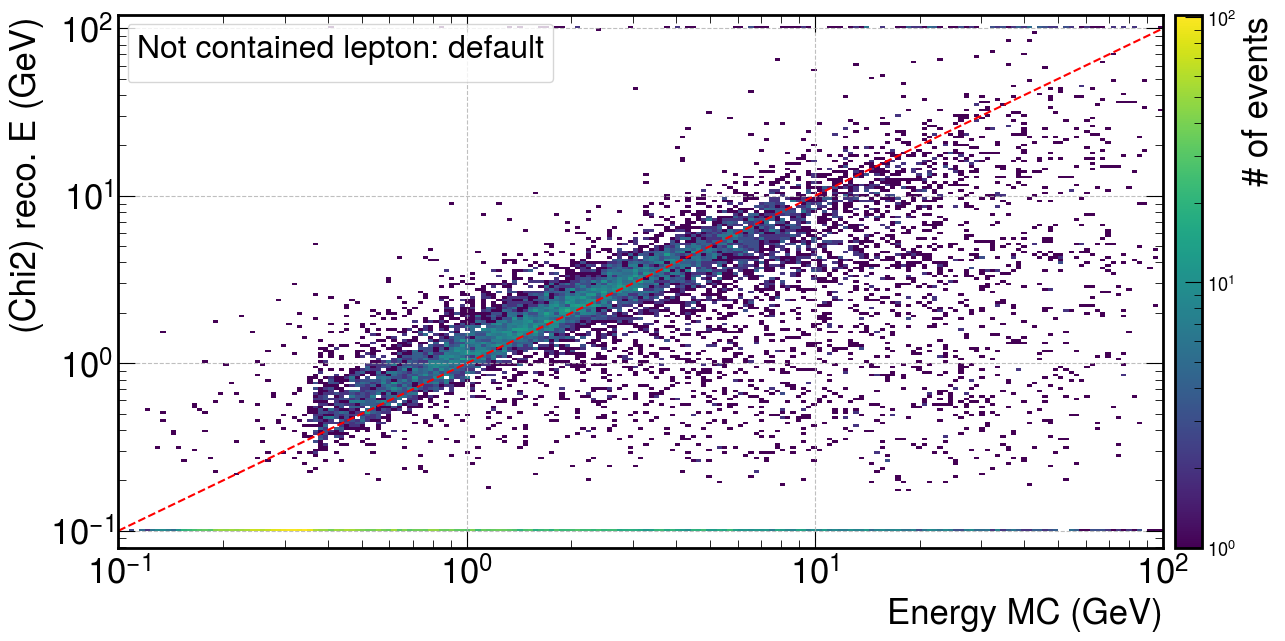

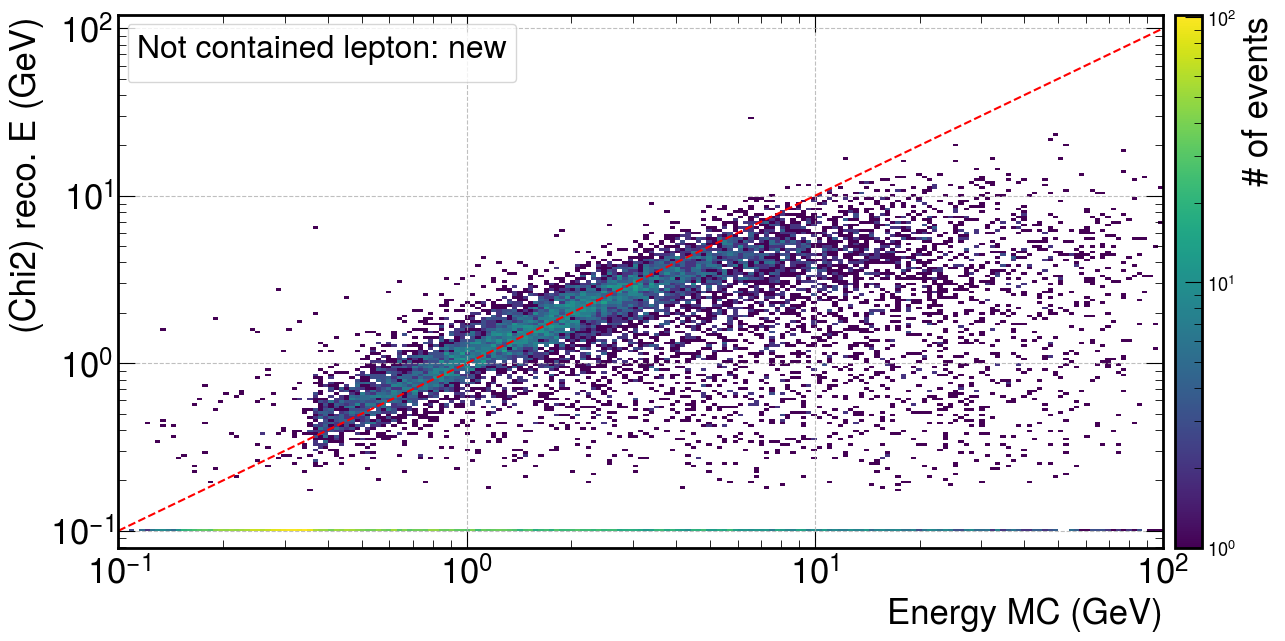

In [21]:

plot_mu_vs_mu(dfnu.filter(pl.col('LongestTrackContNumu')==0),  y='Echi2', label='(Chi2)', lmethod='Not contained lepton: default')
plot_mu_vs_mu(dfnu.filter(pl.col('LongestTrackContNumu')==0),  y='Echi2_new', label='(Chi2)', lmethod='Not contained lepton: new')

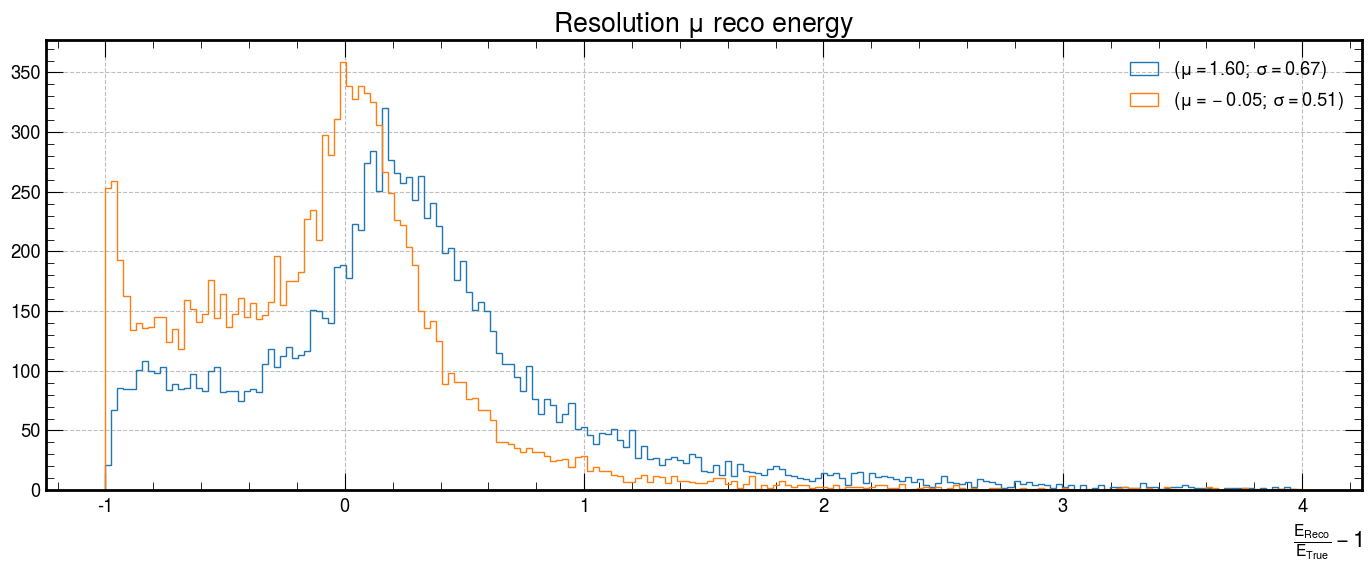

In [24]:
def plot_en_res(df:pl.DataFrame, reco='RecoLepEnNumu', mc='E'):
    
    # plt.figure(figsize=(14, 4))
    df = df.filter((pl.col(mc)>0.2) & (pl.col(mc) < 8))
    Ep  = df[reco]/df[mc]-1
    stddev = manual_std(Ep.to_numpy())
    avg = np.mean(Ep.to_numpy())
    label = rf"($\mu={avg:.2f}$; $\sigma={stddev:.2f}$)"
    binsres = np.linspace(-1,4,200)
    plt.hist(Ep, bins=binsres, histtype='step', label=label);
    plt.title(r'Resolution $\mu$ reco energy')
    plt.xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
    # plt.yscale('log')
    plt.legend()

plot_en_res(df=dfnu.filter(pl.col('LongestTrackContNumu')==0), reco='Ellhd')
plot_en_res(df=dfnu.filter(pl.col('LongestTrackContNumu')==0), reco='Ellhd_new')


In [46]:
total= len(dfnu.filter(pl.col('LongestTrackContNumu')==0)['Ellhd_new'])
fail = len(dfnu.filter(pl.col('LongestTrackContNumu')==0).filter(pl.col('Ellhd_new')==0))
print(total, fail, fail/total)

15546 1870 0.12028817702302844


In [156]:
# Check track len
tracks:pl.DataFrame = anatree_new.reco_tracks.collect()
trknu = tracks.group_by(selection_events()).agg(
   pl.col('trklen_pandoraTrack').sort().last()
).join(
    nu_new, on=selection_events()
)
print(trknu.filter(pl.col('RecoLepEnNumu_mcs_llhd')>0)['trklen_pandoraTrack'].describe())

anatree.nu.collect()["Ev_reco_numu"].describe()



shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 28663.0      │
│ null_count ┆ 0.0          │
│ mean       ┆ 242.343862   │
│ std        ┆ 506.987108   │
│ min        ┆ 20.00279     │
│ 25%        ┆ 71.647575    │
│ 50%        ┆ 149.559479   │
│ 75%        ┆ 302.792999   │
│ max        ┆ 42536.121094 │
└────────────┴──────────────┘


statistic,value
str,f64
"""count""",127720.0
"""null_count""",0.0
"""mean""",7.761417
"""std""",20.853238
"""min""",0.0
"""25%""",0.139392
"""50%""",0.526682
"""75%""",2.466213
"""max""",163.704941


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


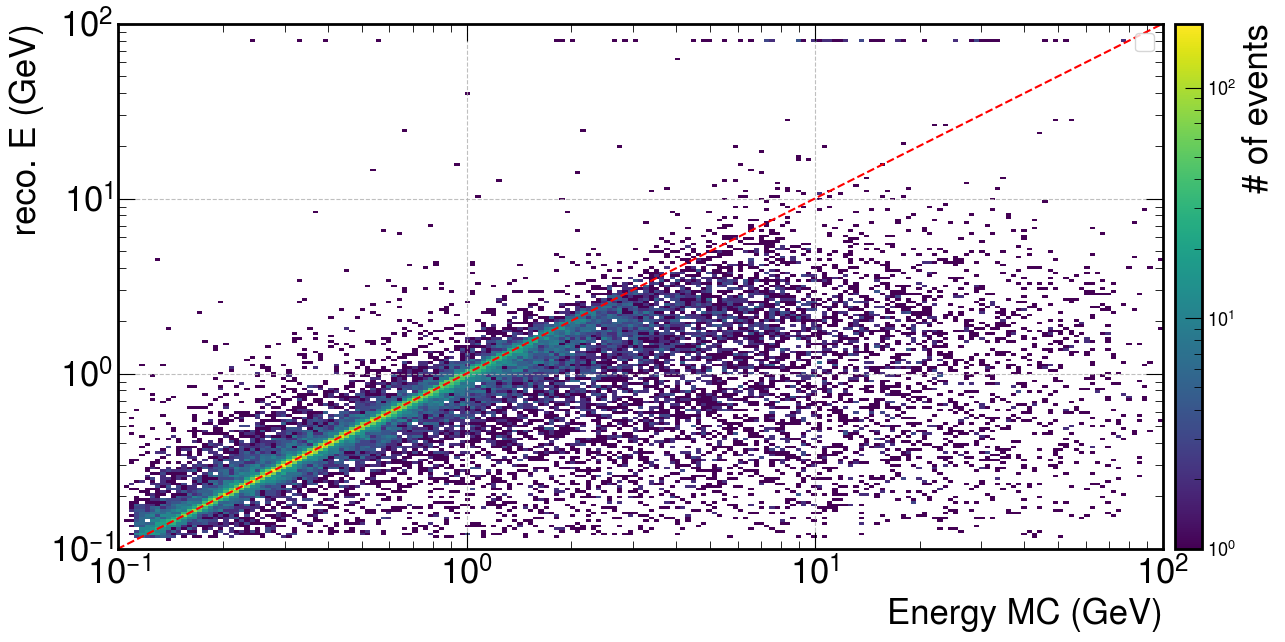

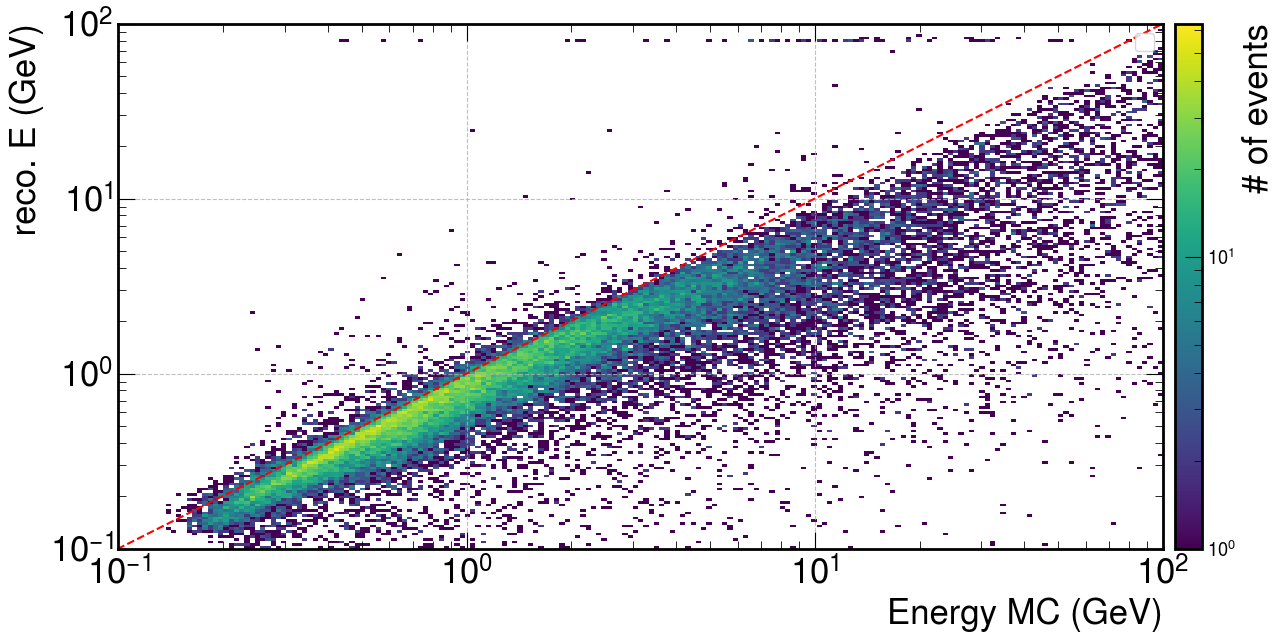

In [9]:
df_new = df.with_columns(
    recoEn = pl.when((pl.col('LongestTrackContNumu') == 1) & (pl.col('TrackMomMethodNumu')==0)).then(
        pl.col('RecoLepEnNumu_range')
    ).otherwise(
        pl.col('RecoLepEnNumu')
    )
).with_columns(
    Ev_reco_numu_new = pl.when(pl.col('TrackMomMethodNumu')!=-1).then(pl.col('recoEn')+pl.col('RecoHadEnNumu')).otherwise(pl.col('Ev_reco_numu'))
)

df_new_chi2 = df.with_columns(
    recoEn = pl.when((pl.col('LongestTrackContNumu') == 1) & (pl.col('RecoLepEnNumu_range')>0)).then(
        pl.col('RecoLepEnNumu_range')
    ).otherwise(
        pl.when((pl.col('LongestTrackContNumu') == 1) & (pl.col('RecoLepEnNumu_range')<=0)).then(0).otherwise(
            pl.when((pl.col('LongestTrackContNumu') <= 0) & (pl.col('RecoLepEnNumu_mcs_chi2')>0)).then(
                pl.col('RecoLepEnNumu_mcs_chi2')
            ).otherwise(0)
        )
    )
).with_columns(
    Ev_reco_numu_new = pl.when(pl.col('recoEn')>0).then(pl.col('recoEn')+pl.col('RecoHadEnNumu')).otherwise(pl.col('Ev_reco_numu'))

)

plot_mu_vs_mu(df_new, label='', lmethod='', y='recoEn')
plot_mu_vs_mu(df_new, label='', lmethod='', y='Ev_reco_numu_new', x='enu_truth')

In [10]:
oldana = Anatree('../normal_ereco.root',load_data=False)
oldana.load_anatree(['nu'])

Loading nu infos


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Loading shower infos
Loading track infos


In [11]:
olddf = oldana.nu
olddf = olddf.filter(
    (pl.col('nuPDG_truth').abs() == 14) & (pl.col('ccnc_truth')==0)
)
olddf = olddf.with_columns(
    recoEn = pl.when((pl.col('LongestTrackContNumu') == 1) & (pl.col('TrackMomMethodNumu')==0)).then(
        pl.col('RecoLepEnNumu_range')
    ).otherwise(
        pl.col('RecoLepEnNumu')
    )
).with_columns(
    Ev_reco_numu_new = pl.when(pl.col('TrackMomMethodNumu')!=-1).then(pl.col('recoEn')+pl.col('RecoHadEnNumu')).otherwise(pl.col('Ev_reco_numu'))
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


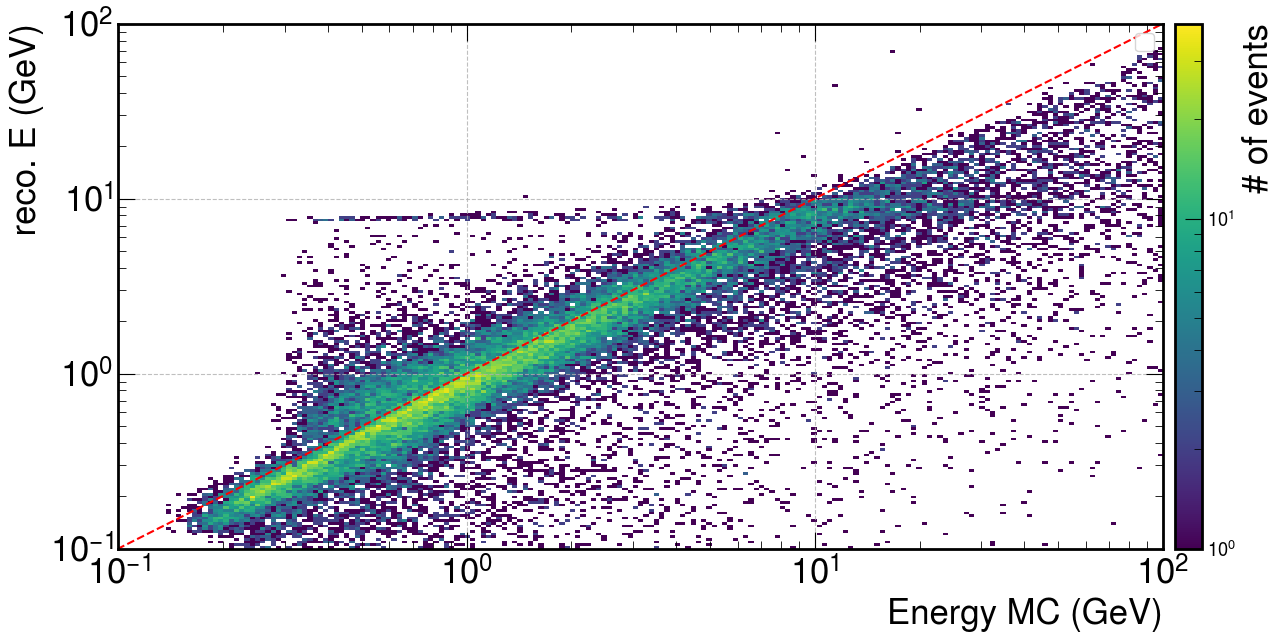

In [26]:
plot_mu_vs_mu(olddf, label='', lmethod='', y='Ev_reco_numu', x='enu_truth')

[None, None]

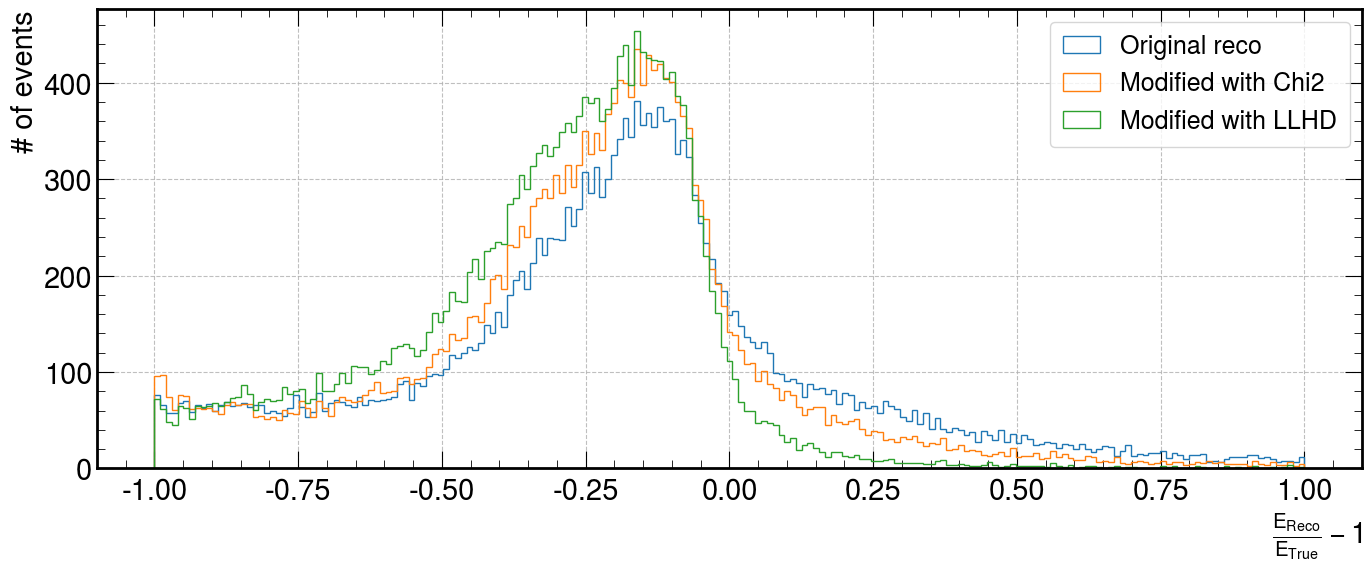

In [13]:
binsres = np.linspace(-1,1,200)
enres_new = df_new['Ev_reco_numu_new']/df_new['enu_truth']-1
enres_new_chi2 = df_new_chi2['Ev_reco_numu_new']/df_new_chi2['enu_truth']-1
enres_old = olddf['Ev_reco_numu']/olddf['enu_truth']-1

bh, hedges, _ = plt.hist(enres_old, bins=binsres, histtype='step', weights=olddf['nuWeight_truth']/olddf['nuWeight_truth'].max(), label='Original reco');
bh, hedges, _ = plt.hist(enres_new_chi2, bins=binsres, histtype='step', weights=df_new_chi2['nuWeight_truth']/df_new_chi2['nuWeight_truth'].max(), label='Modified with Chi2');
bh, hedges, _ = plt.hist(enres_new, bins=binsres, histtype='step', weights=df_new['nuWeight_truth']/df_new['nuWeight_truth'].max(), label='Modified with LLHD');
fontsize = 21
plt.xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$', fontsize=fontsize)
plt.ylabel(f'# of events', fontsize=fontsize)

plt.tick_params(labelsize=21)


legend = plt.legend(frameon=True, fontsize=fontsize-3)
plt.setp(legend.get_title(),fontsize='x-large')
# bm, bmin, bmax = compute_median_sigma(enres_new,bh, hcenter, 0.68)
# plt.axvline(hcenter[bm],  linestyle='-', c='C0')
# plt.axvline(hcenter[bmax],linestyle='--', c='C0')
# plt.axvline(hcenter[bmin],linestyle='--', c='C0')



In [17]:
def compute_median_sigma(vals:np.ndarray, cred=0.68):
    total = vals.sum()
    cum_ratio = (np.cumsum(vals[:])/total)

    binmedian = len(cum_ratio[cum_ratio<=0.5])-1
    bin_id = np.arange(len(cum_ratio))
    bin_min = bin_id[cum_ratio<=0.5-cred/2.]
    bin_max = bin_id[cum_ratio<0.5+cred/2]
    bin_max = bin_max[-1]
    if len(bin_min) > 0:
        bin_min = bin_min[-1]
    else:
        bin_min = 0
        # bin_max = bin_id[cum_ratio<cred][-1]

    return binmedian, bin_min, bin_max
    
    
def hist2dcred(df:pl.DataFrame, var, binsx, binsy, cred=0.68):
    from scipy.stats import binned_statistic_2d
    fig = plt.gcf()
    H, edgex, edgey, binnumber = binned_statistic_2d(df['enu_truth'], df[var]/df['enu_truth']-1,None,'count', bins=(binsx,binsy))
    edxwidth = (edgex[1:]-edgex[:-1])/2
    edywidth = (edgey[1:]-edgey[:-1])/2
    edxcenter = edgex[:-1] + edxwidth
    edycenter = edgey[:-1] + edywidth
    error_vals = []
    medians = []
    x = []
    for i in range(len(H)):
        if max(H[i,:]) > 1:
            bm, bmin, bmax = compute_median_sigma(H[i,:], cred)
            if bm == bmin == bmax == 0:
                continue
            plt.plot(edxcenter[i], edycenter[bm], '+', mew=1, markersize=10, color='black')
            plt.plot(edxcenter[i], edycenter[bmin], '_', mew=3, markersize=10, color='red')
            plt.plot(edxcenter[i], edycenter[bmax], '_', mew=3, markersize=10, color='red')
            x.append(edxcenter[i])
            error_vals.append(edycenter[bmax]-edycenter[bmin])
            medians.append(edycenter[bm])
        else:
            pass

    custom_label = [
        plt.Line2D([0],[0], color='black',marker='+', markersize=10, mew=1, label='Median'),
        plt.Line2D([0],[0],lw=2, color='red',  label=r'1$\sigma$'),
        ]
    plt.legend(frameon=True, handles=custom_label)
    return x, medians, error_vals
def show_plot_2dres(df:pl.DataFrame, var, title='', binsres=None, binse=None):
    plt.figure(figsize=(15,4))
    if binsres is None:
        binsres = np.linspace(-1,2,100)
    if binse is None:
        binse = np.logspace(-1,2,50)
    plt.hist2d(df['enu_truth'], df[var]/df['enu_truth']-1, bins=[binse, binsres], norm='log')
    plt.title(title)
    x, medians, error_val = hist2dcred(df, var=var, binsx=binse, binsy=binsres);

    plt.xscale('log')
    plt.tick_params(labelsize=fontsize)
    ax = plt.gca()
    ax.set_ylabel(r'$\frac{E_{Reco}}{E_{True}} - 1$', fontsize=fontsize)
    ax.set_xlabel(r'$E_{True}$ (GeV)', fontsize=fontsize)
    ax.set_xscale('log')
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    return x, medians, error_val


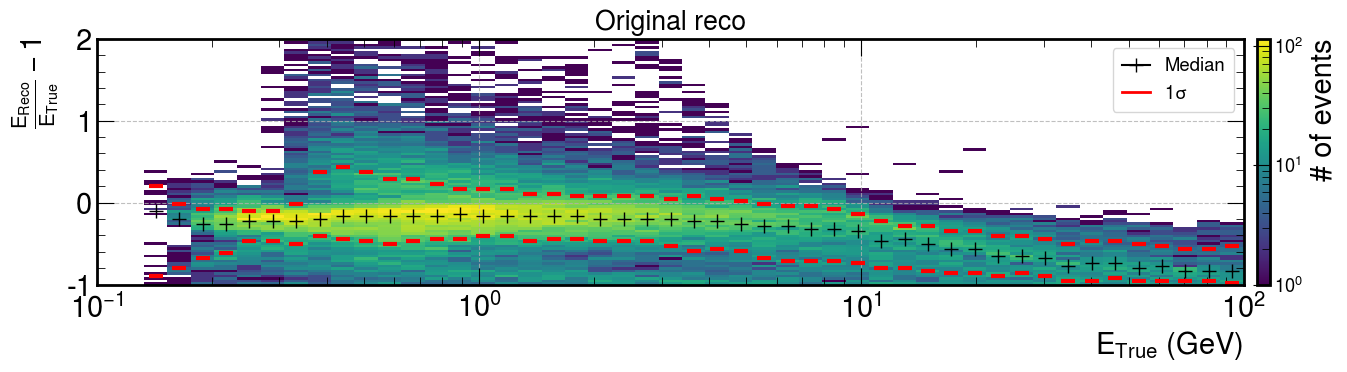

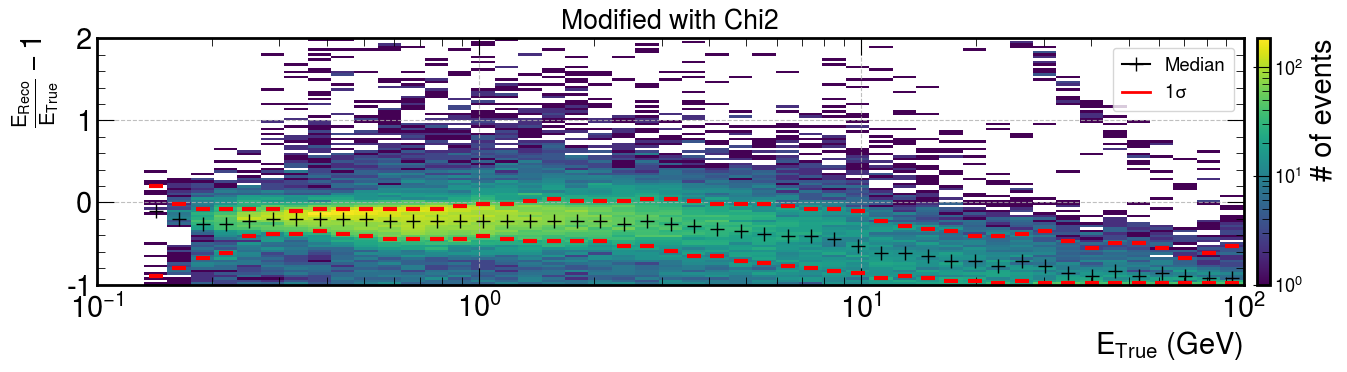

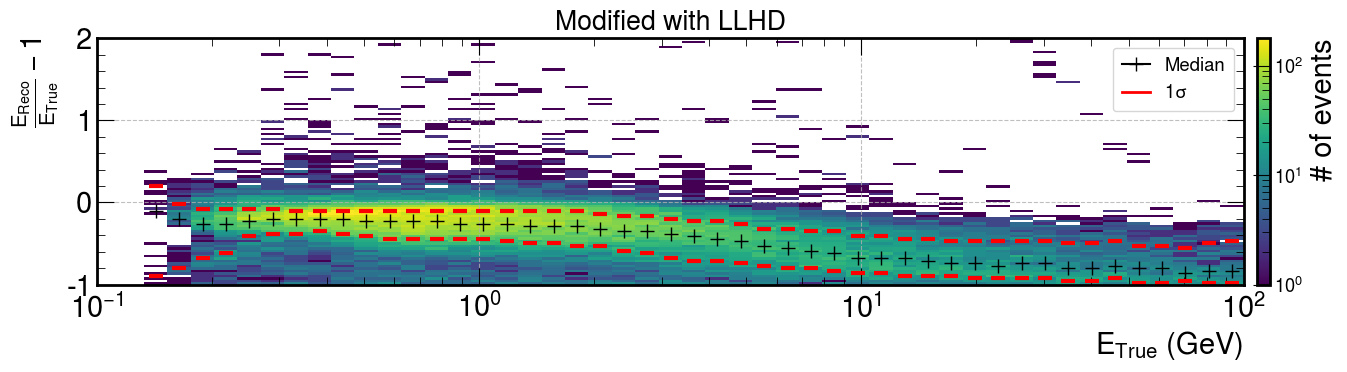

In [23]:

xold, yold, eryold = show_plot_2dres(olddf, var='Ev_reco_numu', title='Original reco')
xchi2, ychi2, erychi2 = show_plot_2dres(df_new_chi2, var='Ev_reco_numu_new', title='Modified with Chi2')
xllhd, yllhd, eryllhd = show_plot_2dres(df_new, var='Ev_reco_numu_new', title='Modified with LLHD')

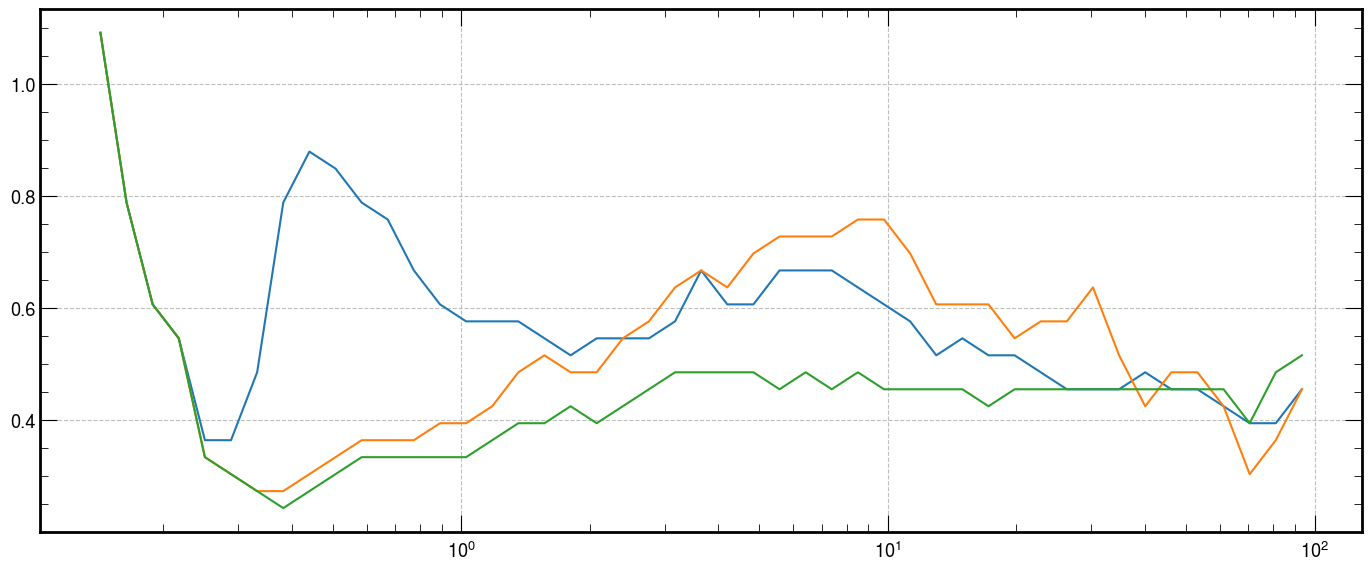

In [24]:
plt.plot(xold, eryold)
plt.plot(xchi2, erychi2)
plt.plot(xllhd, eryllhd)
plt.xscale('log')

In [19]:
df_with_something = df.filter(
    pl.col('RecoLepEnNumu_range') > 0
)
total_ev = len(df_with_something)
failed_llhd = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_llhd')<=0))
failed_chi2 = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_chi2')<=0))
print(f'Total ev: {total_ev}')
print(f'Failed llhd: {failed_llhd} ({failed_llhd*100/total_ev:.2f} %)')
print(f'Failed chi2: {failed_chi2} ({failed_chi2*100/total_ev:.2f} %)')

df_with_something = df_with_something.filter(
    pl.col('LongestTrackContNumu') != 1
)
total_ev = len(df_with_something)
failed_llhd = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_llhd')<=0))
failed_chi2 = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_chi2')<=0))

print('Not contained')
print(f'Total ev: {total_ev}')
print(f'Failed llhd: {failed_llhd} ({failed_llhd*100/total_ev:.2f} %)')
print(f'Failed chi2: {failed_chi2} ({failed_chi2*100/total_ev:.2f} %)')

Total ev: 36598
Failed llhd: 8781 (23.99 %)
Failed chi2: 8660 (23.66 %)
Not contained
Total ev: 16336
Failed llhd: 4052 (24.80 %)
Failed chi2: 2693 (16.49 %)


In [21]:

df_with_something = olddf.filter(
    pl.col('RecoLepEnNumu_range') > 0
)
total_ev = len(df_with_something)
failed_llhd = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_llhd')<=0))
failed_chi2 = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_chi2')<=0))
print(f'Total ev: {total_ev}')
print(f'Failed llhd: {failed_llhd} ({failed_llhd*100/total_ev:.2f} %)')
print(f'Failed chi2: {failed_chi2} ({failed_chi2*100/total_ev:.2f} %)')

df_with_something = df_with_something.filter(
    pl.col('LongestTrackContNumu') != 1
)
total_ev = len(df_with_something)
failed_llhd = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_llhd')<=0))
failed_chi2 = len(df_with_something.filter(pl.col('RecoLepEnNumu_mcs_chi2')<=0))

print('Not contained')
print(f'Total ev: {total_ev}')
print(f'Failed llhd: {failed_llhd} ({failed_llhd*100/total_ev:.2f} %)')
print(f'Failed chi2: {failed_chi2} ({failed_chi2*100/total_ev:.2f} %)')

Total ev: 36434
Failed llhd: 5435 (14.92 %)
Failed chi2: 8604 (23.62 %)
Not contained
Total ev: 16261
Failed llhd: 3570 (21.95 %)
Failed chi2: 2673 (16.44 %)


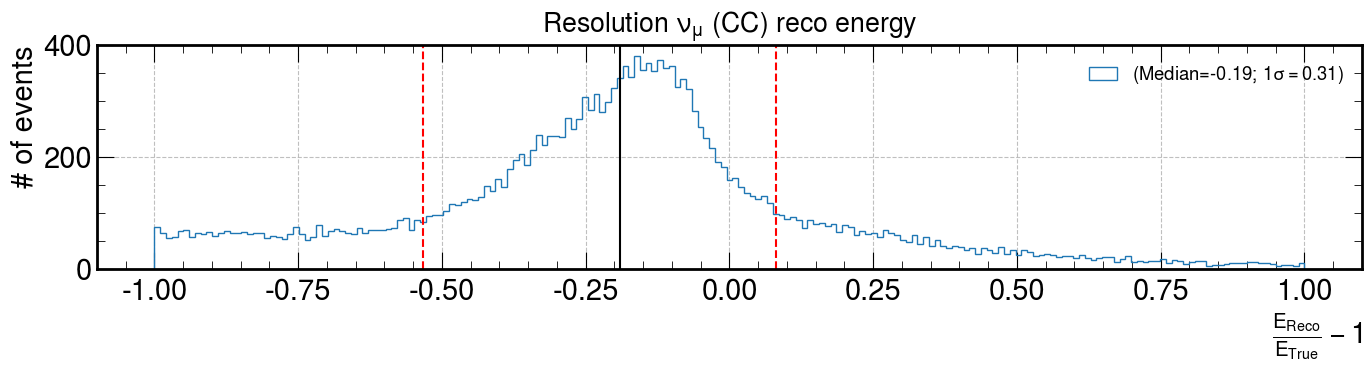

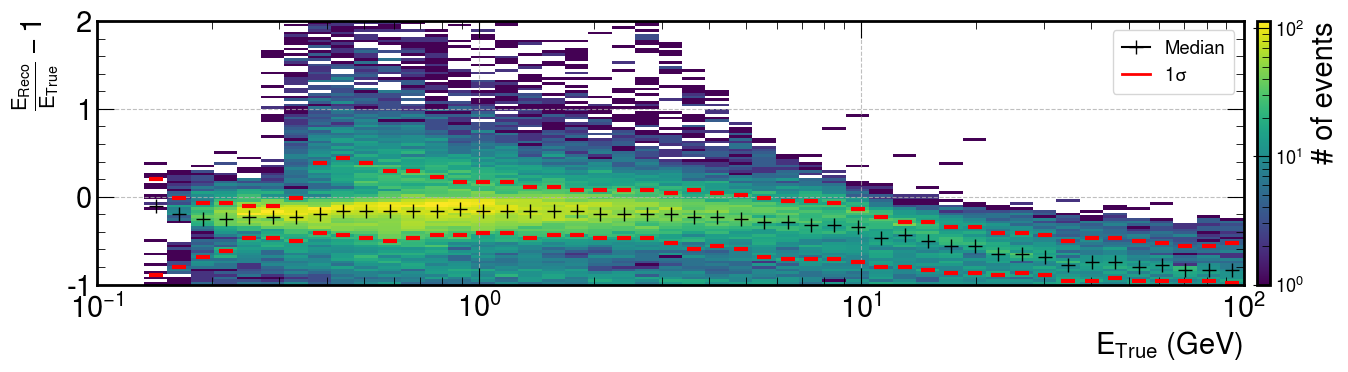

In [ ]:
def show_plot_1dres(df:pl.DataFrame, var, title=''):
    plt.figure(figsize=(14,4))
    binsres = np.linspace(-1,1,200)
    hheight, hedges, _ = plt.hist(df[var]/df['enu_truth']-1, bins=binsres, weights=df['nuWeight_truth']/df['nuWeight_truth'].max(), histtype='step', label='wait')
    hcenters = (hedges[1:] + hedges[:-1])/2
    bm, bmin, bmax = compute_median_sigma(hheight, 0.68)
    plt.title(title)
    medians = hcenters[bm]
    error_val = (hcenters[bmax] - hcenters[bmin])/2
    plt.axvline(hcenters[bmin], ls='--', c='r')
    plt.axvline(hcenters[bmax], ls='--', c='r')
    plt.axvline(hcenters[bm], ls='-', c='k')
    label = rf"(Median={medians:.2f}; $1\sigma={error_val:.2f}$)"

    plt.tick_params(labelsize=fontsize)
    ax = plt.gca()
    ax.set_ylabel('# of events', fontsize=fontsize)
    ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$', fontsize=fontsize)

    plt.legend().get_texts()[0].set_text(label)

show_plot_1dres(olddf, var='Ev_reco_numu', title=r'Resolution $\nu_\mu$ (CC) reco energy')
show_plot_2dres(olddf, var='Ev_reco_numu', title='');

In [ ]:
olddfnue = oldana.nu
olddfnue = olddfnue.filter(
    (pl.col('nuPDG_truth').abs() == 12) & (pl.col('ccnc_truth')==0)
)

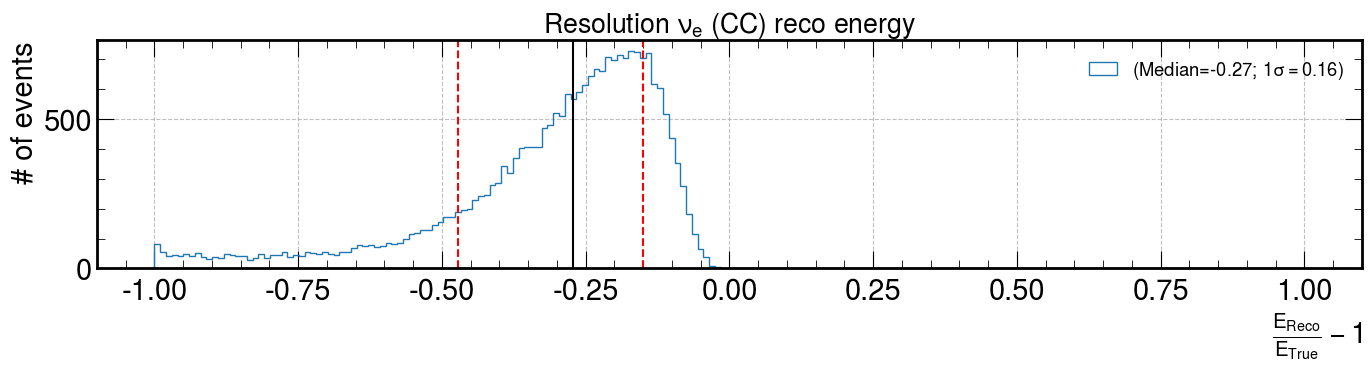

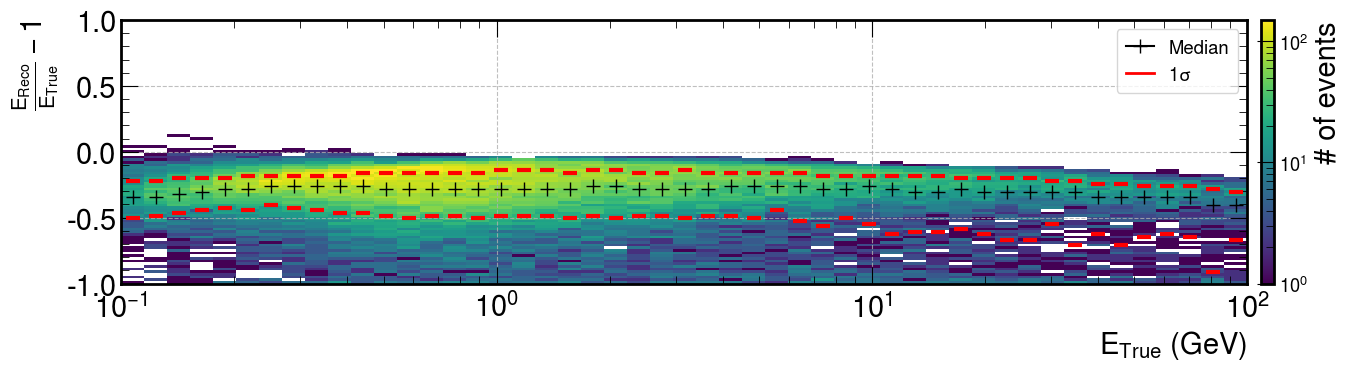

In [ ]:

show_plot_1dres(olddfnue, var='Ev_reco_nue', title=r'Resolution $\nu_e$ (CC) reco energy')
show_plot_2dres(olddfnue, var='Ev_reco_nue', title='', binsres=np.linspace(-1,1,100));

run,subrun,event,nuPDG_truth,ccnc_truth,nuvtxx_truth,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,lep_mom_truth,lep_dcosx_truth,lep_dcosy_truth,lep_dcosz_truth,mode_truth,nuWeight_truth,Q2_truth,W_truth,X_truth,Y_truth,pot,Ev_reco_nue,RecoLepEnNue,RecoHadEnNue,RecoMethodNue,Ev_reco_numu,RecoLepEnNumu,RecoHadEnNumu,RecoMethodNumu,LongestTrackContNumu,TrackMomMethodNumu,RecoLepEnNumu_range,RecoLepEnNumu_mcs_chi2,RecoLepEnNumu_mcs_llhd,Ev_reco_nc,nuvtxx,nuvtxy,nuvtxz
i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f64,f32,f32,f32,i16,f32,f32,f32,i16,i16,i16,f32,f32,f32,f32,f64,f64,f64
1497,1,25201,14,0,254.29213,-239.733795,850.396851,3.506681,0.474672,0.870252,-0.131727,2.105677,0.821558,0.558953,0.112317,1,3.9526248e7,2.051261,1.206727,0.78117,0.398769,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,2.586391,2.812985,-99999.0,254.069626,-239.660126,850.444031
1497,1,25202,-14,1,-74.490112,-383.822388,536.706909,1.692236,-0.973393,0.091639,-0.210047,1.577442,-0.895445,-0.053152,-0.441988,0,6.4872904e7,0.215788,0.9388,1.001038,0.067836,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,0.0,-99999.0,-40.414368,-349.046326,628.65033
1497,1,25203,14,0,-97.171188,-419.298553,1227.462524,0.190718,0.846817,-0.04055,0.530347,0.08844,0.118292,0.165426,0.979102,0,6.8320936e7,0.020724,0.979918,0.208499,0.277534,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,0.0,-99999.0,-96.734985,-419.07431,1226.571167
1497,1,25204,16,0,196.164902,349.553009,1069.138184,87.232079,-0.32467,0.944353,0.052804,65.237411,-0.323229,0.943364,0.074752,2,8.89505e6,3.824883,6.189803,0.092709,0.251862,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,0.0,-99999.0,195.695312,350.36441,1069.79187
1497,1,25205,14,0,282.284546,68.525764,1332.67395,0.425602,0.698178,-0.507746,0.504728,0.220373,0.190629,0.952567,0.237227,0,4.589922e7,0.240167,0.990799,0.705791,0.425771,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.273967,0.263144,-99999.0,282.33728,68.317558,1332.552856
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6422672,1,74396,12,1,-281.563812,-596.129395,340.425354,1.223063,-0.05688,0.011856,0.998317,0.435483,0.173991,-0.521949,0.835042,1,6.8981248e7,0.194371,1.471783,0.131425,0.643941,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,0.0,-99999.0,-281.658539,-596.190735,340.044861
6422672,1,74397,12,1,11.799652,-548.747437,944.309753,0.304619,0.972369,0.175128,0.154401,0.191166,0.778483,-0.430992,0.4563,0,4.5317444e7,0.028891,1.032339,0.135607,0.372443,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,0.0,-99999.0,12.155544,-548.537903,944.407471
6422672,1,74398,12,0,139.017593,253.169296,1074.418579,0.764691,-0.093388,-0.895427,-0.435307,0.42574,-0.167123,-0.91174,-0.375232,1,4.7908308e7,0.003032,1.230866,0.004764,0.443252,-99999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-99999.0,0.0,0.0,-99999.0,139.099197,253.670639,1074.557007
